In [52]:
import pandas as pd
import Levenshtein
import rdkit
import rdkit.Chem as Chem
rdkit.RDLogger.DisableLog('rdApp.*')

ROOT_PATH = "/data/rsg/nlp/yujieq/bms/"

gold = pd.read_csv(ROOT_PATH + 'data/valid_folds.csv')

pred_smiles = []
with open(ROOT_PATH + 'output/swin_base_384_epoch_16_multi_aug2/valid_atomtok_beam.txt') as f:
    for line in f:
        if line.startswith('ID'):
            pred_smiles.append([])
            continue
        pred_smiles[-1].append(line.strip())

In [53]:
from tqdm import tqdm

n_correct = 0
for i, row in tqdm(gold.iterrows()):
    num_atom = row['num_atom']
    mol = Chem.MolFromSmiles(pred_smiles[i][0])
    if mol and mol.GetNumAtoms() == num_atom:
        n_correct += 1
print(n_correct)
print(n_correct / len(gold))

242419it [01:17, 3136.66it/s]

238859
0.9853146824300075


In [49]:
pred = pd.read_csv(ROOT_PATH + 'output/swin_base_384_epoch_16_multi_aug/prediction_valid.csv')

def is_valid(str_, format_='atomtok'):
    if format_ == 'atomtok':
        mol = Chem.MolFromSmiles(str_)
    elif format_ == 'inchi':
        mol = Chem.MolFromInchi(str_)
    else:
        raise NotImplemented
    return mol is not None

cnt = 0
for i, row in pred.iterrows():
    if not is_valid(pred_smiles[i][0]):
        cnt += 1
#         print([is_valid(s) for s in pred_smiles[i]])
#         break

print(cnt)

233


In [8]:
import multiprocessing

def convert_smiles_to_inchi(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        inchi = Chem.MolToInchi(mol)
    except:
        inchi = None
    return inchi


def batch_convert_smiles_to_inchi(smiles_list, num_workers=16):
    with multiprocessing.Pool(num_workers) as p:
        inchi_list = p.map(convert_smiles_to_inchi, smiles_list)
    n_success = sum([x is not None for x in inchi_list])
    r_success = n_success / len(inchi_list)
    inchi_list = [x if x else 'InChI=1S/H2O/h1H2' for x in inchi_list]
    return inchi_list, r_success

In [16]:
import numpy as np
np_pred = np.array(pred_smiles)
flatten_pred = np_pred.flatten()

pred_inchi_list, r = batch_convert_smiles_to_inchi(flatten_pred)
print(r)

pred_inchi = np.array(pred_inchi_list).reshape(np_pred.shape)

0.8044460211452072


In [35]:
gold_inchi = gold['InChI'].values
nbest, score_d, score_em = [], [], []

for n in [1,2,4,8,10]:
    distances, ems, success = [], [], []
    for pred, gi in zip(pred_inchi, gold_inchi):
        d = [Levenshtein.distance(gi, pi) for pi in pred[:n]] 
        distances.append(min(d))
        ems.append(min(d) == 0)
        success.append(any([pi != 'InChI=1S/H2O/h1H2' for pi in pred[:n]]))
    print(n)
    print(np.mean(distances))
    print(np.mean(ems))
    print(np.mean(success))
    nbest.append(n)
    score_d.append(np.mean(distances))
    score_em.append(np.mean(ems))

1
0.9915971932893048
0.9311275106324174
0.9985768442242563
2
0.5434145013385915
0.9700807279957429
0.9992286083186549
4
0.38795226446771913
0.9828891299774357
0.9995957412579047
8
0.3070881407810444
0.9878268617558855
0.9997772451829271
10
0.2881663565974614
0.9886642548645115
0.9998143709857725


Text(0, 0.5, 'InChI Exact Match')

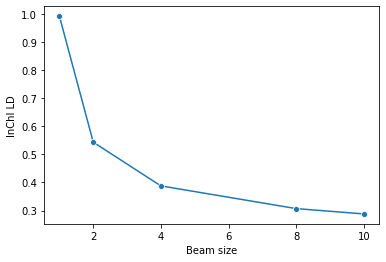

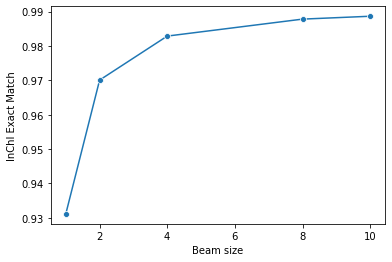

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=nbest, y=score_d, marker='o')
plt.xlabel('Beam size')
plt.ylabel('InChI LD')

plt.figure()
sns.lineplot(x=nbest, y=score_em, marker='o')
plt.xlabel('Beam size')
plt.ylabel('InChI Exact Match')

In [22]:
gold_smiles = gold['SMILES'].values

distances, ems = [], []
for pred, gs in zip(pred_smiles, gold_smiles):
    d = [Levenshtein.distance(gs, ps) for ps in pred]
    distances.append(min(d))
    ems.append(min(d) == 0)

print(np.mean(distances))
print(np.mean(ems))

0.10628704845742289
0.9856364393880017
